<a href="https://colab.research.google.com/github/Coyote-Schmoyote/portrait-generation-dcgan/blob/main/GAN_portrait_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image generation with GAN
This notebook looks into the process of generating art portraits using GAN. The project is inspired by the AI-generated portrait of Edmond de Belamy (2018) that was sold at Christie's for $432,000. 
## 1. Problem Definition
Generate new images based on the input images from the art portraits.
## 2. Data
The data used in this project is the combination of  Portrait Paintings dataset (https://www.kaggle.com/datasets/deewakarchakraborty/portrait-paintings) and Art Portraits dataset (https://www.kaggle.com/datasets/karnikakapoor/art-portraits), both available on Kaggle. The Portrait Painting dataset consists of 5734 images, and Art Portraits dataset consists of 4117 images.
## 3. Approach
For this project, we will take the following approach:
1. Import the tools
2. Clean the dataset
3. Explore and process the images
4. Build Discriminator and Generator, and combine them into a GAN model
5. Describe the training steps
6. Train the model
7. Display the result (generated portraits)

##4. Evaluation
There is no function to evaluate the performance of a GAN model, which means that the performance of the model will be evaluated based on the quality of the generated images.

# Import the tools
First, we will import all the necessary tools. We will use the same ones we used for the MNIST digit generation: `os`, `numpy`, `random`, `matplotlib`, `open cv`, and `tensorflow`.

In [3]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import numpy as np
import random 
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import preprocessing

In [3]:
cv2.__version__

'4.6.0'

In [4]:
tf.__version__

'2.8.2'

# Clean and prepare dataset
The goal of this project is to generate portraits based on the input images. The original combined dataset consisted of 9851 art portraits. However, not all images were suitable for the task, because some of them featured more than one person in the painting, depicted the whole body, or were too abstract.


To recevie the desirable result, we have to follow the  rule "garbage in, garbage out," and clean our dataset properly. FOr this project, I removed images that depict full-body portraits, have more than one person in the image, side portaits, too abstract portraits (where it is impossible to tell wether an image depicts a face), portraits of children, black and white portraits, pencil drawings and prints. GAN will learn the features of the input images, and try to generate something similar, so we will receive the result based on the style of images in our dataset. This is a space for some creativity and experimentation, for example, you can choose images depicting only one gender, one face, only particular color scheme, etc. Depending on this, the output will also differ.

The process of cleaning the dataset might take several hours. 

In [5]:
project_folder = "/content/drive/MyDrive/ml-projects/GAN/Images/"

In [6]:
image_list = os.listdir(project_folder)
print(f"Number of images after data cleaning: {len(image_list)}")

Number of images after data cleaning: 5606


## How many images is enough for a GAN model?
GAN models typically require a lot of input data to generate high-quality images. It typically takes tens or even hundreds of thousands of images to train GAN. In our MNIST hand-writeen digit generation project, for example, we used a dataset of 60,000 images. In keras face generation example (https://keras.io/examples/generative/dcgan_overriding_train_step/), a dataset of 200,000 images is used. However, often we don't have access to that many examples. In this case, several thousands can be enough. Image generation based on CIFAR10 dataset that features 10 different classes of object, for example, uses approximately 6,000 images per class. 

In our case, we have 5,606 images after cleaning the data. This should be enough to train our GAN model. It is also worth noting, that the more images we input, the faster we can get plausible result, and the less images we have, the more epochs we might have to go through to receive similar output. 

# Explore and process the images
Exploratory Data Analysis (EDA) is important in any machine learning project, including GAN image generation. We need to familiarize ourselves with our dataset, check the data types of the files, and pre-process it for deep learning.


## Display images
First, let's select a random image from our `project_folder` and display it.

In [7]:
def select_random_image(folder):
  img_list = os.listdir(folder)
  image = os.path.join(folder, random.choice(img_list))
  image = plt.imread(image)
  image_array = np.array(image)
  return image_array

In [8]:
select_random_image(project_folder)

array([[[ 88,  78,  77],
        [ 88,  78,  77],
        [ 85,  75,  74],
        ...,
        [ 38,  37,  35],
        [ 42,  41,  39],
        [ 44,  43,  41]],

       [[ 79,  70,  65],
        [ 75,  66,  61],
        [ 70,  59,  55],
        ...,
        [ 38,  37,  35],
        [ 41,  40,  38],
        [ 43,  42,  40]],

       [[ 83,  70,  61],
        [ 81,  68,  59],
        [ 72,  59,  50],
        ...,
        [ 37,  36,  34],
        [ 41,  40,  38],
        [ 44,  43,  41]],

       ...,

       [[ 63,  54,  45],
        [ 68,  59,  50],
        [ 77,  68,  59],
        ...,
        [ 36,  35,  31],
        [ 29,  28,  23],
        [116, 115, 110]],

       [[ 69,  60,  51],
        [ 67,  58,  49],
        [ 70,  61,  52],
        ...,
        [ 41,  40,  36],
        [ 35,  34,  30],
        [122, 121, 116]],

       [[ 82,  73,  64],
        [ 73,  64,  55],
        [ 70,  61,  52],
        ...,
        [ 50,  49,  45],
        [ 44,  43,  39],
        [132, 131, 126]]

As we remember from our previous projects with images, computers keep images as arrays of integers. In order to display the images, we typically need to use help tools. There are 3 libraries that can do this job: `matplotlib` and `cv2` (we already have experience working with them), and another library is `Pillow`, or `PIL`.
For now, let's use `plt.imshow()` to display the random image.

Each time that we run the cell, we will get a new random image from our 5,606 images.

In [9]:
def display_random_image(folder):
  image = select_random_image(folder)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Sample Portrait")

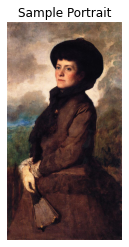

In [10]:
display_random_image(project_folder)

Great! A lovely portrait. Now, let's display several images, so we can understand better the general context of our dataset, and see how the images relate to each other. To do this, we will create an empty array `images`, and append the images to the array by looping through our `select_random_image()` function that we wrote earlier. Here, we loop through the function 4 times to display 4 random images. Similar to the previous `display_random_image()` function, each time we refresh the cell, we will get a different combination of images.

In [11]:
def display_random_images(folder):
  images = []
  for _ in range(4):
    images.append(select_random_image(folder))
  
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=len(images), sharey=True, figsize = (14, 7))
  fig.tight_layout()
  ax1.imshow(images[0])
  ax1.axis("off")
  ax2.imshow(images[1])
  ax2.axis("off")
  ax3.imshow(images[2])
  ax3.axis("off")
  ax4.imshow(images[3])
  ax4.axis("off");

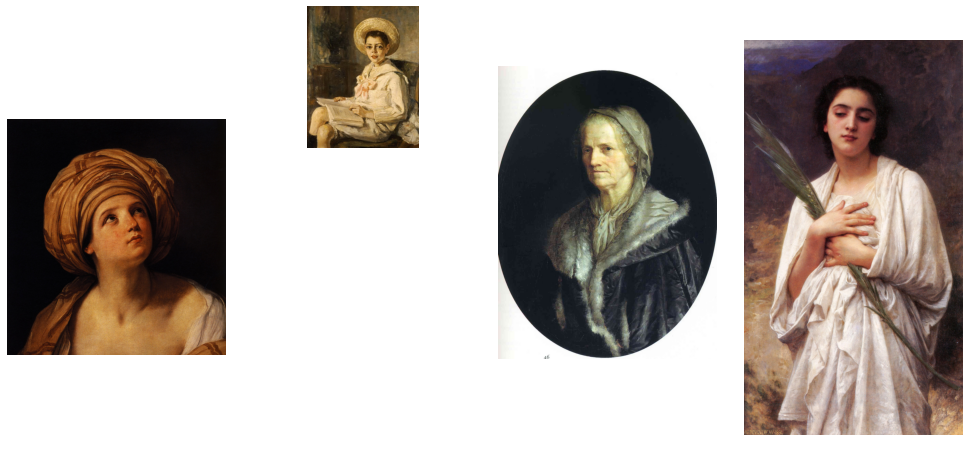

In [16]:
display_random_images(project_folder)

## Process images
Great! Now tht we know what our images look like, we are ready to begin preparing the images for the deep learning algorithm.
Generally, image preparation follows the following steps:
1. Resize the images
2. Change the shape of the array
3. Normalize pixel values from 0 to 1
4. Save the images as a dataset


In [17]:
def create_image_array(path):
  for image in os.listdir(project_folder):
    image_array = cv2.imread(os.path.join(project_folder, image))
  return image_array

In [18]:
image_array = create_image_array(project_folder)
print(f"Original image shape: {image_array.shape}")

Original image shape: (944, 786, 3)


## How to choose an image size for GAN?
There are no specific guidelines for chooseing the size of the input images, however, there are several things to keep in mind. For example, the sizes are often chosen as the power of two, for example, 32x32px, 64x64px, 96x96px, etc. However, technically, any image size should work fine. The smaller the input image, the less features it has, and the faster it will train. At the same time, the smaller the image, the poorer the quality. But, if we choose an image that is too big, we might not have enough memory or computing power, particularly if working on local server or free services such as Google Colab.

For our MNIST handwritten digit generation, we used 23x23px size. Let's see the differences in sizes on an example from our dataset.

In [19]:
def display_resized_image(image, size):
  image = cv2.resize(image, (size, size))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  print(f"Resized {size}x{size}px image shape: {image.shape}")
  plt.imshow(image);

Resized 112x112px image shape: (112, 112, 3)


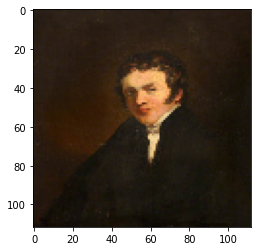

In [20]:
display_resized_image(image_array, 112)

Resized 64x64px image shape: (64, 64, 3)


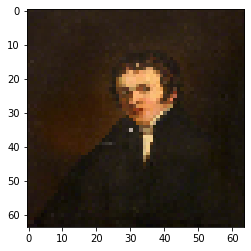

In [21]:
display_resized_image(image_array, 64)

Resized 23x23px image shape: (23, 23, 3)


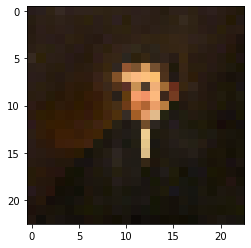

In [22]:
display_resized_image(image_array, 23)

We can see that the quality differs quite a bit. 23x23 px size that we used for MNIST project would be too small for portrait generation, because we cannot see any distinct features. 112x112 has a good quality, however, it might be too complicated for our network to grasp all the features. So for this example, we will stick with 64x64 size.

Now that we have familiarized ourselves with the images and decided on the size, let's save the size, that path, and the color channels as variables.
In our previous project with MNIST handwritten-digit generation, we generated black and white images, and therefore we had only one color channel. This time, we are generated RGB images with 3 color channels.

In [23]:
size = 96
path = project_folder
color_channels = 3

* First, let's write a function that will load the images into the `real_samples` array. We will tell the machine to try to read the imaged, resize them, convert them to RGB (because we are using open-cv, and as we remember, open-cv uses BGR instead of RGB), and append them to the array. We tell the algorithm to *try*, because some of the files in our relatively large dataset might be corrupted in one way or another, which may cause the function to crash. If we tell it to *try*, however, it will simply skip the files it cannot process.

* Second, we will ahve to create a dataset based on the loaded images. We will convert the images to a numpy array and reshape it into a `[number of samples, width, height, color channels]` format, so it can be read by our neural network. After we converted the images into a numpy array, we have to normalize the pixel values.

### Pixel Normalization
Pixel normalization is a necessary step in image processing that changes the range of pixel intensity values. Pixel values usually range between 0 and 255, and while they can be presented to a neural network in this format, it might cause problems during the learning stage, such as slow trainging of the model. Instead, we can normalize pixels to the range of 0 to 1 (particularly if we will use Sigmoid activation function in the output layer of the generator) or -1 to 1 (if we will use tanh activation function in the output layer of the generator). We can normalize the pixel to 0 to 1 range by simply dividing all the pixels by 255.0, or by using `(img - 127.5) / 127.5` formula to normalize the values betweeen -1 and 1.

In [24]:
def load_real_samples(path, size):
  real_samples = []
  for image in os.listdir(path):
    try:
      images = cv2.imread(os.path.join(path, image))
      images = cv2.resize(images, (size, size))
      images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
      real_samples.append(images)
    except Exception as e:
      pass
  return real_samples

In [25]:
real_samples = load_real_samples(path, size)
print(f"Images in project folder: {len(os.listdir(project_folder))}, Images in dataset: {len(real_samples)}")

Images in project folder: 5606, Images in dataset: 5604


In [26]:
def create_dataset(path, size, color_channels):
  real_samples = load_real_samples(path, size)
  dataset = np.array(real_samples).reshape(-1, size, size, color_channels) #-1 means there can be any number
  dataset = dataset / 255.0
  return dataset

As a result, we get a dataset with a shape of `(5604, 96, 96, 3)`, in which `5604` stands for the number of samples, `96, 96` stands for the size of the samples, and `3` stands for the numebr of color channels.

In [27]:
dataset = create_dataset(path, size, color_channels)
dataset.shape

(5604, 96, 96, 3)

## Keras API
In this project, we will use the Keras Sequential API to build our DCGAN network.
Keras is an API developed by Google that simplifies the process of building deep neural networks. Keras is built on top of TensorFlow 2, and provides inbuild modules for the majority of neural network computations, runs smoothly on CPU and GPU, supports almost all neural network models, and gained popularity for being flexible and fast.

Keras provides two ways of building deep neural network models: Sequential and functional. The sequential API allows us to create models layer-by-layer for most deep learning tasks. In this project, we will build a Sequential model. Functional models, on the other hand, are more complex, but allows more control over the resulting model architecture.


# DCGAN
For this project, we will implement the GAN  architecture. The goal of our project is to generate art portraits based on the examples from the training dataset. The process is eseentially the same to the one we followed for out MNIST handwritten digit generation project.

First, the generator takes input images to create new synthetic images that it can then pass to the discriminator. 

Then, the discriminator has to recognize the authentic images from the ones created by the generator. It takes both real and fake images and returns probabilities between 0 and 1 of whether an image is real or fake. 

The discriminator network is a typical convolutional network that categorizes images, and the generator is an inverse convolutional network, which takes a vector of random noise and upsamples it to an image. 


## Discriminator
First, let's build the Discriminator. We will follow a similar architecture we did in our MNIST generation project with two main differences. 
1. Input shape

We will have a different `input_shape`, because we have different size of the images `(96, 96)` and a different number of color channels `3`. 
2. Number of hidden layers

Instead of 2 sets of convolution + activation + droupout layers, we will use 3. Generally, the more complicated the task, the more convolutional layers we will need. Typically, most GAN architectures use 3-5 hidden layers. 
3. Number of filters

Here, the deeper we go into the network, the more filters we are going to use: our first convolutional layer will have 64 filters, and the last to 128 filters each. 



In [28]:
def make_discriminator(in_shape=(96,96,3)):
  #instantiate the model
  model = keras.Sequential(name="Discriminator")

  #add 1st set of convolutional + normalization layers
  model.add(layers.Conv2D(64, kernel_size= 4, strides=2, padding="same", input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #add 2nd set of convolutional + normalization layers
  model.add(layers.Conv2D(128, kernel_size = 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #add 3rd set of convolutional + normalization layers
  model.add(layers.Conv2D(256, kernel_size = 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #Add final flatten and output layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation="sigmoid"))

  #compile the model
  model.compile(loss = "binary_crossentropy", 
                optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                metrics = ["accuracy"])
  return model

In [29]:
discriminator = make_discriminator()

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Generator 
The second part of the GAN network is the Generator. In the summary of the Discriminator, we could see that each convolution reduced the size of the image. So, from `(96,96)` we scaled it down to `(12,12)` with 256 filters. We will use this final output shape of `12,12, 256` as the input shape for our Generator.

The generator will also have 3 sets of convolutional layers, but, unlike the ones in Discirminator, the `Conv2DTranspose` layers will upsample the image. How much the image is upsampled will depend on the value of `stride`. In our case, we set `strides=2`, and so the previous size will be multiplied by 2.  

In [30]:
# make the generator
def make_generator(latent_dim):
	model = keras.Sequential(name="Generator")
 
	# foundation for 8x8 image
	n_nodes = 12 * 12 * 256
	model.add(layers.Dense(n_nodes, input_dim=latent_dim))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Reshape((12, 12, 256)))
 
	# upsample to 16x16
	model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
	# upsample to 32x32
	model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
 	# upsample to 64x64
	model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
 
	model.add(layers.Conv2D(3, (5,5), activation='sigmoid', padding='same'))
	return model


In [31]:
latent_dim = 256
generator = make_generator(latent_dim)
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 36864)             9474048   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 36864)             0         
                                                                 
 reshape (Reshape)           (None, 12, 12, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 24, 256)      1048832   
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 24, 24, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 48, 256)      1048832   
 ranspose)                                               

## Compile GAN model
Now that we finished building our Discriminator and Generator, we are ready to compile our joint GAN model. 

In [32]:
def make_gan(generator, discriminator):
  discriminator.trainable = False
  model = keras.Sequential(name="GAN")

  #add generator
  model.add(generator)

  # add discriminator
  model.add(discriminator)

  #compile model
  optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy",
                optimizer=optimizer)
  return model

In [33]:
gan = make_gan(generator, discriminator)

gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 96, 96, 3)         13707779  
                                                                 
 Discriminator (Sequential)  (None, 1)                 695745    
                                                                 
Total params: 14,403,524
Trainable params: 13,707,779
Non-trainable params: 695,745
_________________________________________________________________


# Define training step for the Generator
Now let's describe the train step of GAN.
1. First, we will select random samples from our dataset with the function `select_random_samples()`, and attach `1` labels to them, to let know the Generator model that these are the real samples (references).
2. Then, we will generate the latent points that will become the input for the Generator by writing a `generate_latent_points()` function. It can be compared to giving a canvas to a painter.
3. Then, by defining `generate_fake_samples()`, we will. tell the Generator to make a prediction (paint a portrait) on the latent dimension (canvas), and attach `0` labels, to denote that these images are fake.

In [34]:
def select_real_samples(dataset, n_samples):
  random_samples = np.random.randint(0, dataset.shape[0], n_samples)
  real_images = dataset[random_samples]
  real_labels = np.ones((n_samples, 1))
  return real_images, real_labels

In [35]:
def generate_latent_points(latent_dim, n_samples):
  generator_input = np.random.randn(latent_dim * n_samples)
  generator_input = generator_input.reshape(n_samples, latent_dim)
  return generator_input

In [36]:
def generate_fake_samples(generator, latent_dim, n_samples):
  generator_input = generate_latent_points(latent_dim, n_samples)
  fake_images = generator.predict(generator_input)
  fake_labels = np.zeros((n_samples, 1))
  return fake_images, fake_labels

## Saving the output
Since there are no effective evaluation metrics for GAN models, we will have to evaluate how successful our model is by looking at the generated images. We will use `matplotlib` in `save_plot()` to generate a plot of a 3x3 matrix of images for better comparison. This way, each time the model saves generated images, we will receive 9 different generated portraits. The number could be any, for example, we can generate only for images by setting `n=2`, or 16 images by setting the `n=4`.

Then, with the help of `ummarize_performance()` we will evaluate how weel the discriminator can distinguish between the real and fake images. Then, we will the model in the output folder.

In [5]:
output_folder = "/content/drive/MyDrive/ml-projects/GAN/output/"
output_images = os.path.join(output_folder, "images/")
output_models = os.path.join(output_folder, "models/")

In [6]:
def save_plot(examples, epoch, n=3):

  fig = plt.figure(figsize=(12, 12))
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :, :])
  filename = "generated_portrait_e%03d.png" % (epoch+1)
  plt.savefig(os.path.join(output_images, filename))
  plt.close()

In [39]:
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
  real_images, real_labels = select_real_samples(dataset, n_samples)
  _, accuracy_real = discriminator.evaluate(real_images, real_labels, verbose=0)
  fake_images, fake_labels = generate_fake_samples(generator, latent_dim, n_samples)
  _, accuracy_fake = discriminator.evaluate(fake_images, fake_labels, verbose=0)
  print(">Accuracy detecting real: %.0f%%, detecting fake: %.0f%%" % (accuracy_real*100, accuracy_fake*100))
  save_plot(fake_images, epoch)
  model_folder = "models/"
  filename = "generator_model_%03d.h5" % (epoch + 1)
  generator.save(os.path.join(output_models, filename))

## Training the GAN
In this step, we will describe the order in which we are going to train GAN using the functions we wrote in the previous step. Our new function `train()` will accept the generator, discriminator, our GAN model, the dataset, latent dimensions, number of epochs, and batch size as arguments. 

### How many epochs should I train GAN for?
The simple answer to this question is: it depends. Typically, the more data we have, the less epochs we will need to get plausible results. As we remember, GAN models are extremely hungry for data, so if we have enough data, for example, 200,000 images, we might need as little as 100 epochs. However, if we have less data, there might be cases when we need to train a model for 1,000 or even 10,000 epochs. However, there are two things to keep in mind:
* It is not guaranteed that the more epochs you will have, the better images you will get. Sometimes, you can overtrain GAN, and the Generator will start producing poor images.
* Depending on the platform, there might be limitation in terms of notebook running time or GPU memory. For example, free Google Colab version allows only up to 12 hours of uninterrupted runtime without hardware acceleration, and even less so if running the notebook on GPU. 

### GAN training process
1. First, we loop through our batch in each epoch, and construct half of our input for the GAN model made up from real samples, and the other half from fake samples created by the generator.

2. Then, we train the discriminator on that batch, and save its loss as a variable. We let GAN generate latent points and label them as `1`, to fool the discriminator. Using these latent points, we train GAN, and save it as a Generator loss. 
3. Every 10 epochs, we print out the summary of the model's performance and save its output.
4. Repeat steps 1-3 for as many epochs as we determined in `n_epochs`.

In [40]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=400, n_batch=32):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  for epoch in range(n_epochs):
    for batch in range(bat_per_epo):
      real_images, real_labels = select_real_samples(dataset, half_batch)
      fake_images, fake_labels = generate_fake_samples(generator, latent_dim, half_batch)
      images, labels = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))
      
      #train the discriminator
      d_loss, _ = discriminator.train_on_batch(images, labels)
      images_gan = generate_latent_points(latent_dim, n_batch)
      labels_gan = np.ones((n_batch, 1))
      g_loss = gan.train_on_batch(images_gan, labels_gan)
    if (epoch+1) % 10 == 0:
      print(">%d, %d/%d, d=%.3f, g=%.3f" % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))
      summarize_performance(epoch, generator, discriminator, dataset, latent_dim)

In [41]:
discriminator = make_discriminator()
generator = make_generator(latent_dim)
gan = make_gan(generator, discriminator)
latent_dim = 256

In [ ]:
%%time
train(generator, discriminator, gan, dataset, latent_dim)

>10, 175/175, d=0.681, g=0.721
>Accuracy detecting real: 47%, detecting fake: 64%


>20, 175/175, d=0.666, g=0.706
>Accuracy detecting real: 54%, detecting fake: 40%


>30, 175/175, d=0.661, g=0.812
>Accuracy detecting real: 20%, detecting fake: 97%


>40, 175/175, d=0.692, g=0.707
>Accuracy detecting real: 45%, detecting fake: 70%


>50, 175/175, d=0.689, g=0.680
>Accuracy detecting real: 70%, detecting fake: 17%


>60, 175/175, d=0.688, g=0.690
>Accuracy detecting real: 35%, detecting fake: 66%


>70, 175/175, d=0.703, g=0.658
>Accuracy detecting real: 80%, detecting fake: 10%


>80, 175/175, d=0.725, g=0.690
>Accuracy detecting real: 36%, detecting fake: 52%


>90, 175/175, d=0.739, g=0.733
>Accuracy detecting real: 21%, detecting fake: 84%


>100, 175/175, d=0.695, g=0.763
>Accuracy detecting real: 34%, detecting fake: 76%


>110, 175/175, d=0.703, g=0.588
>Accuracy detecting real: 96%, detecting fake: 1%


>120, 175/175, d=0.730, g=0.755
>Accuracy detecting real: 23%, detecting fake: 72%


>130, 175/175, d=0.679, g=0.712
>Accuracy detecting real: 82%, detecting fake: 30%


# Evaluating generated portraits
We ran our GAN model for 130 epochs, which took us approximately 3 hours and 45 minutes. Because we were saving our progress every 10 epochs, we have 13 plots of 9 generated portraits in each.

In [7]:
len(os.listdir(output_images))

13

Now, let's display plots from 5 different epochs: 10, 60, 160, 200, and 250, to see how the GAN was progressing as it was training. We will notice how in the beginning we could only see abstract color blobs, and as the model was training, the images began resembling human figures more and more.

In [8]:
def display_image(folder, epoch_no):
  path = os.path.join(folder, "generated_portrait_e{:03d}.png".format(epoch_no))
  image = cv2.imread(path)
  image = cv2.resize(image, (500, 500))
  print(f"Epoch Nr. {epoch_no}")
  cv2_imshow(image)

Epoch Nr. 10


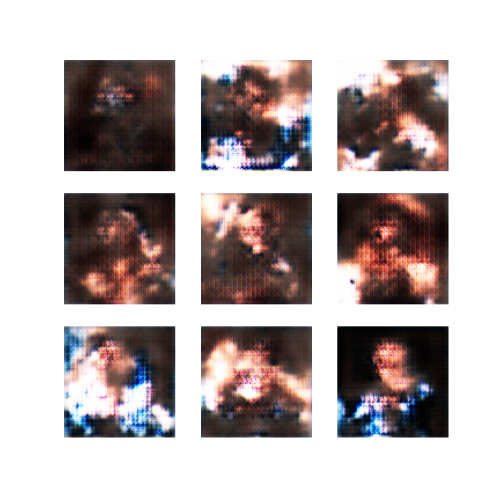

In [9]:
display_image(output_images, 10)

Epoch Nr. 40


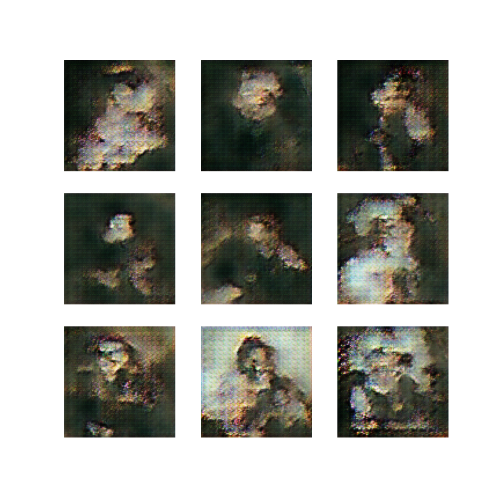

In [11]:
display_image(output_images, 40)

Epoch Nr. 80


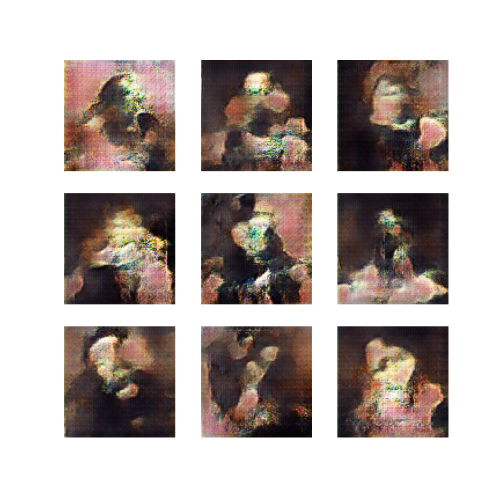

In [12]:
display_image(output_images, 80)

Epoch Nr. 100


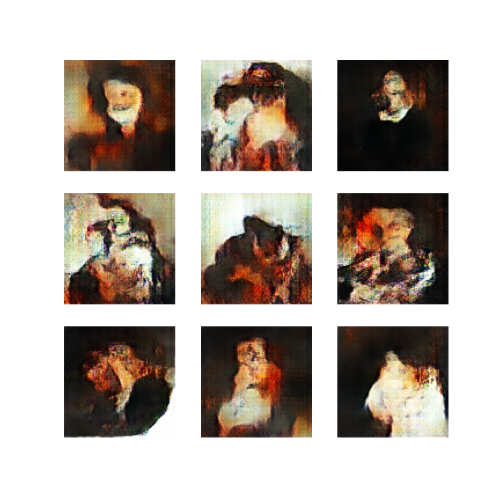

In [13]:
display_image(output_images, 100)

Epoch Nr. 130


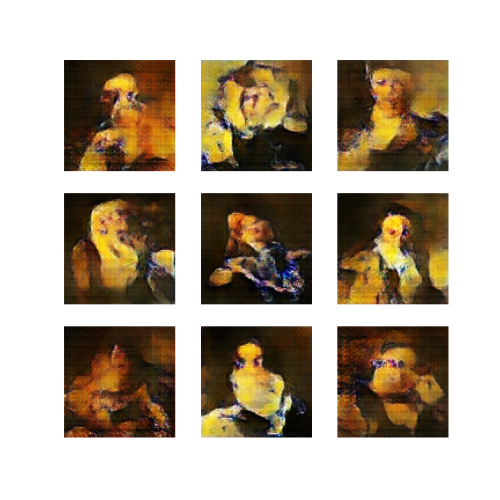

In [14]:
display_image(output_images, 130)

# Conclusion
We demonstrated how we can train a GAN model to generate images inspired by the art portraits. GAN models are extremely usntable, data-hungry and sensitive models, for which any hyperparameter tuning can result in a drastically different output. There are no set fool-proof rules for GAN, which makes it a great area for experimentation and exploration.